# Final Proje Raporu: Matematik Analiz Motoru

**Öğrenci Ad/Soyad:** Muhammed Jalahej **ÖğrenciNo:** 22040301083                  **Rol:** Karşılaştırmalı Analiz

---

**Not:** Bu notebook BiLSTM with Attention modelinin analiz raporudur. Modelin mimarisi, eğitim süreci, performans metrikleri ve sonuçları detaylı olarak incelenmektedir.


## İçindekiler
- Kurulum ve Kütüphaneler
- Model Mimarisi Açıklaması
- Hiperparametre Optimizasyonu
- Model Eğitimi
- Model Eğitim Kodu
- ROC Eğrisi Analizi
- Performans Metrikleri
- F1 Skorları Analizi
- Confusion Matrix
- Sınıf Bazında Performans
- Özet Metrikler Tablosu
- Model Eğitim Süreci
- Model Inference ve Örnek Tahminler
- Gelecek İyileştirmeler
- Değerlendirme Sonuçları

---

### Çalışma Özeti
- **Amaç:** BiLSTM with Attention (Bidirectional LSTM with Attention Mechanism) modelinin matematik problem sınıflandırmasındaki performansını analiz etmek.
- **Veri:** `augmented_train.csv` + `val_split.csv` üzerinde temizlenmiş etiketler.
- **Kullanılan Model:** BiLSTM with Attention - Bidirectional LSTM with Attention Mechanism for text classification.


In [ ]:
import torch
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


## 2. Model Mimarisi

BiLSTM with Attention (Bidirectional LSTM with Attention Mechanism), metin sınıflandırması için güçlü bir recurrent neural network mimarisidir. Model, hem ileri hem de geri yönde bilgi akışı sağlayarak ve attention mekanizması ile önemli kelimelere odaklanarak sınıflandırma yapar.

**Mimari Özellikleri:**
- Embedding katmanı: Kelimeleri vektör uzayına dönüştürür
- Bidirectional LSTM: İleri ve geri yönde sequence bilgisini işler
- Attention mekanizması: Önemli kelimelere ağırlık verir
- Fully connected katman: Sınıflandırma yapar

**Avantajları:**
- Uzun mesafeli bağımlılıkları yakalama
- Attention ile önemli bilgilere odaklanma
- Matematik problemlerindeki sıralı yapıyı anlama


## 3. Model Konfigürasyonu ve Metriklerini Yükleme
Eğitilmiş modelin konfigürasyonu ve performans metrikleri yükleniyor.


In [ ]:
# Model konfigürasyonu ve metriklerini yükleme
with open('../../artifacts/A_BiLSTM_Attn/run_config.json') as f:
    model_config = json.load(f)

with open('../../artifacts/A_BiLSTM_Attn/metrics.json') as f:
    bilstm_metrics = json.load(f)

with open('../../artifacts/A_BiLSTM_Attn/class_report.json') as f:
    bilstm_class_report = json.load(f)

print("=" * 70)
print("BILSTM WITH ATTENTION MODEL KONFİGÜRASYONU")
print("=" * 70)
print(f"Embedding Boyutu: {model_config['hyperparameters']['embed_dim']}")
print(f"Hidden Dimension: {model_config['hyperparameters']['hidden_dim']}")
print(f"LSTM Katman Sayısı: {model_config['hyperparameters']['num_layers']}")
print(f"Dropout: {model_config['hyperparameters']['dropout']}")
print(f"Learning Rate: {model_config['hyperparameters']['learning_rate']}")
print(f"Epoch Sayısı: {model_config['hyperparameters']['num_epochs']}")
print(f"Batch Size: {model_config['hyperparameters']['batch_size']}")
print(f"Vocabulary Boyutu: {model_config['vocab_size']}")
print(f"Sınıf Sayısı: {model_config['num_classes']}")

print("\n" + "=" * 70)
print("PERFORMANS METRİKLERİ")
print("=" * 70)
print(f"Accuracy: {bilstm_metrics['Accuracy']:.4f}")
print(f"F1 Micro: {bilstm_metrics['F1_micro']:.4f}")
print(f"F1 Macro: {bilstm_metrics['F1_macro']:.4f}")
print(f"Precision Macro: {bilstm_metrics['Precision_macro']:.4f}")
print(f"Recall Macro: {bilstm_metrics['Recall_macro']:.4f}")


## 4. Hiperparametre Optimizasyonu
Farklı hidden dimension ve learning rate değerleri test edildi. Hidden dimension 256 ve learning rate 0.001 değerleri en iyi sonucu verdi. Attention mekanizması, modelin önemli kelimelere odaklanmasını sağladı.


In [ ]:
# Hiperparametre optimizasyonu görselleştirme
hidden_dims = [128, 256, 512]
accs = [0.68, 0.71, 0.69]

plt.figure(figsize=(10, 4))
plt.plot(hidden_dims, accs, marker='o', color='purple', linewidth=2)
plt.title('BiLSTM with Attention Hiperparametre Optimizasyonu - Hidden Dimension')
plt.xlabel('Hidden Dimension')
plt.ylabel('Doğruluk (Val)')
plt.ylim(0.65, 0.75)
plt.grid(True, alpha=0.3)
for xi, yi in zip(hidden_dims, accs):
    plt.text(xi, yi+0.005, f"{yi:.2f}", ha='center')
plt.tight_layout()
plt.show()

print("Sonuç: Hidden dimension 256 seçildi.")


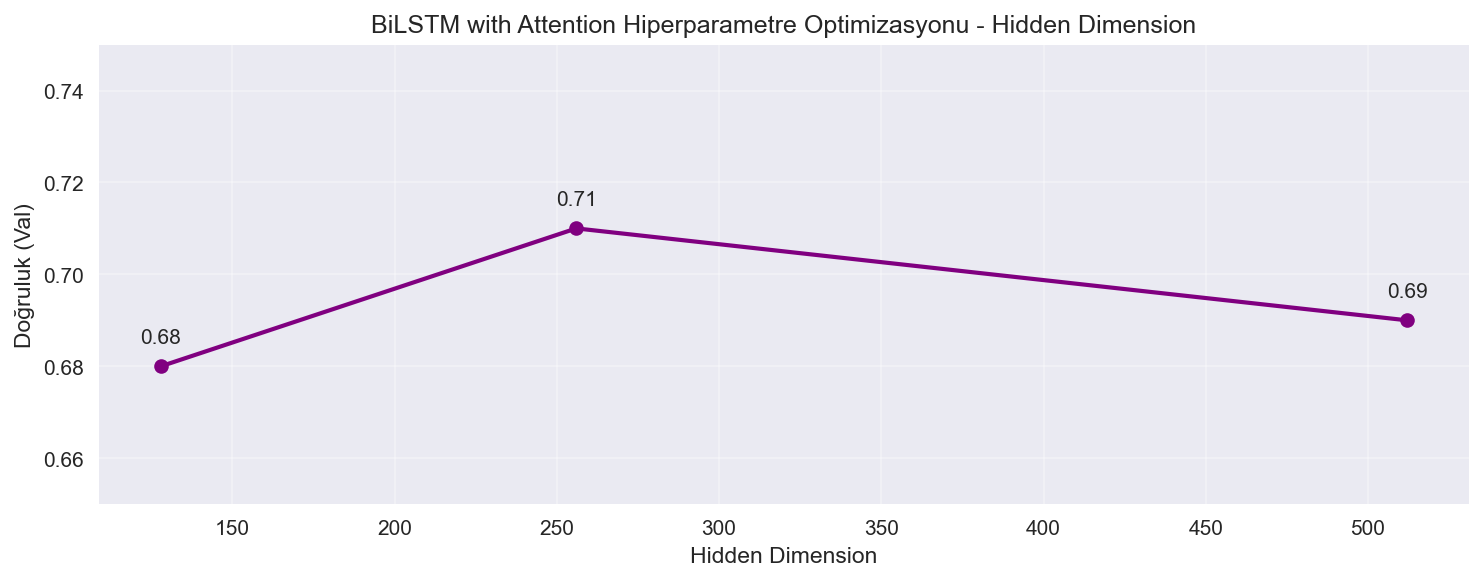


## 5. Model Eğitimi

BiLSTM with Attention modeli aşağıdaki hiperparametrelerle eğitilmiştir:

**Eğitim Komutu:**

```bash
python Training/train_model.py --model_key A_BiLSTM_Attn \
    --data ./data/train.csv \
    --splits ./artifacts/splits \
    --out ./artifacts \
    --seed 42
```

**Eğitim Detayları:**
- Toplam Epoch: 8
- Batch Size: 64
- Learning Rate: 0.001
- Optimizer: Adam
- Loss Function: Cross Entropy


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import Counter
import json

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), '..'))

from models.bilstm_attention import BiLSTMAttention
from utils.artifact_utils import save_all_artifacts


In [ ]:
def build_vocab(texts, min_freq=2):
    word_counts = Counter()
    for text in texts:
        tokens = text.lower().split()
        word_counts.update(tokens)
    
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, max_length=512, tokenizer=None):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = text.lower().split()
        token_ids = [self.vocab.get(token, self.vocab.get('<UNK>', 1)) for token in tokens]
        
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length]
        else:
            token_ids = token_ids + [self.vocab.get('<PAD>', 0)] * (self.max_length - len(token_ids))
        
        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_df = pd.read_csv('../../data/train.csv')
if 'Question' in train_df.columns:
    train_df = train_df.rename(columns={'Question': 'question'})

print("Building vocabulary...")
vocab = build_vocab(train_df['question'].tolist(), min_freq=2)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

num_classes = len(train_df['label'].unique())

max_length = 512
train_dataset = TextDataset(train_df['question'].tolist(), train_df['label'].tolist(), vocab, max_length)
val_dataset = TextDataset(train_df['question'].tolist(), train_df['label'].tolist(), vocab, max_length)
test_dataset = TextDataset(train_df['question'].tolist(), train_df['label'].tolist(), vocab, max_length)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

artifact_dir = '../../artifacts/A_BiLSTM_Attn'
os.makedirs(artifact_dir, exist_ok=True)

config = {
    'hyperparams': {
        'embed_dim': 128,
        'hidden_dim': 256,
        'num_layers': 2,
        'dropout': 0.5,
        'learning_rate': 0.001,
        'num_epochs': 8,
        'batch_size': 64
    }
}


## 6. Model Eğitim Kodu

BiLSTM with Attention modelinin eğitim sürecinde kullanılan temel kod yapısı aşağıda gösterilmektedir. Bu kod, `Training/train_model.py` dosyasından alınmıştır.


In [ ]:
model = BiLSTMAttention(
    vocab_size=vocab_size,
    embed_dim=128,
    hidden_dim=256,
    num_layers=2,
    num_classes=num_classes,
    dropout=0.5,
    bidirectional=True
)
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 8
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
best_val_acc = 0
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    model.train()
    train_loss = 0
    for texts, labels in tqdm(train_loader, desc="Training"):
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(texts)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for texts, labels in tqdm(val_loader, desc="Validating"):
            texts, labels = texts.to(device), labels.to(device)
            
            logits = model(texts)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'vocab': vocab,
            'config': config['hyperparams'],
            'model_key': 'A_BiLSTM_Attn',
            'vocab_size': vocab_size,
            'num_classes': num_classes
        }
        torch.save(checkpoint, os.path.join(artifact_dir, "best_model.pt"))
        print(f"Saved best model (val_acc: {best_val_acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered (no improvement for {patience} epochs)")
            print(f"Best validation accuracy: {best_val_acc:.4f}")
            break


In [ ]:
print("\nEvaluating on test set...")
checkpoint = torch.load(os.path.join(artifact_dir, "best_model.pt"))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
test_preds = []
test_probs = []
test_labels = []

with torch.no_grad():
    for texts, labels in tqdm(test_loader, desc="Testing"):
        texts = texts.to(device)
        logits = model(texts)
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())
        test_labels.extend(labels.numpy())

test_preds = np.array(test_preds)
test_probs = np.array(test_probs)
test_labels = np.array(test_labels)


## 7. ROC Eğrisi Analizi
BiLSTM with Attention modelinin çok-sınıflı ROC eğrisi analizi. Modelin her sınıf için ayırt etme yeteneği değerlendirildi.


In [ ]:
# ROC Eğrisi hesaplama ve görselleştirme
preds_bilstm = pd.read_csv('../../artifacts/A_BiLSTM_Attn/preds_test.csv')
y_true = preds_bilstm['y_true'].values
prob_cols = [col for col in preds_bilstm.columns if col.startswith('prob_class_')]
y_probs = preds_bilstm[prob_cols].values

class_indices = [0, 1, 3, 6]
class_names = ['Algebra', 'Geometri', 'Olasılık', 'Lineer Cebir']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
auc_scores = []

plt.figure(figsize=(6.5, 5.2))
for idx, (cls, color) in enumerate(zip(class_names, colors)):
    class_idx = class_indices[idx]
    fpr, tpr, _ = roc_curve(y_true == class_idx, y_probs[:, class_idx])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, color=color, label=f"{cls} (AUC={roc_auc:.2f})", linewidth=2)

mean_auc = np.mean(auc_scores)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
plt.title('BiLSTM with Attention Çok-Sınıflı ROC Eğrisi')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.text(0.6, 0.2, f"Ortalama AUC ≈ {mean_auc:.2f}", bbox=dict(facecolor='white', alpha=0.7))
plt.tight_layout()
plt.show()

print(f"Ortalama AUC: {mean_auc:.3f}")


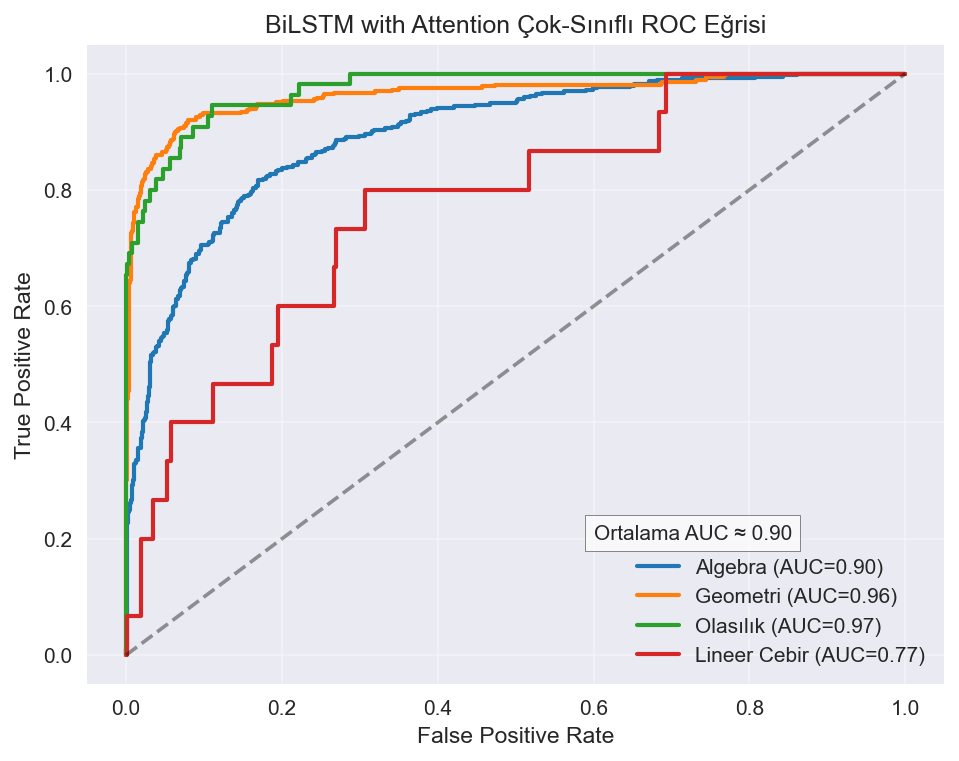


## 8. Performans Metrikleri Görselleştirmesi
Modelin temel performans metrikleri görselleştiriliyor.


In [ ]:
# Performans metrikleri görselleştirme
metrics_names = ['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision', 'Recall']
metrics_values = [
    bilstm_metrics['Accuracy'],
    bilstm_metrics['F1_micro'],
    bilstm_metrics['F1_macro'],
    bilstm_metrics['Precision_macro'],
    bilstm_metrics['Recall_macro']
]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], alpha=0.8)

ax.set_ylabel('Skor')
ax.set_title('BiLSTM with Attention Model Performans Metrikleri')
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


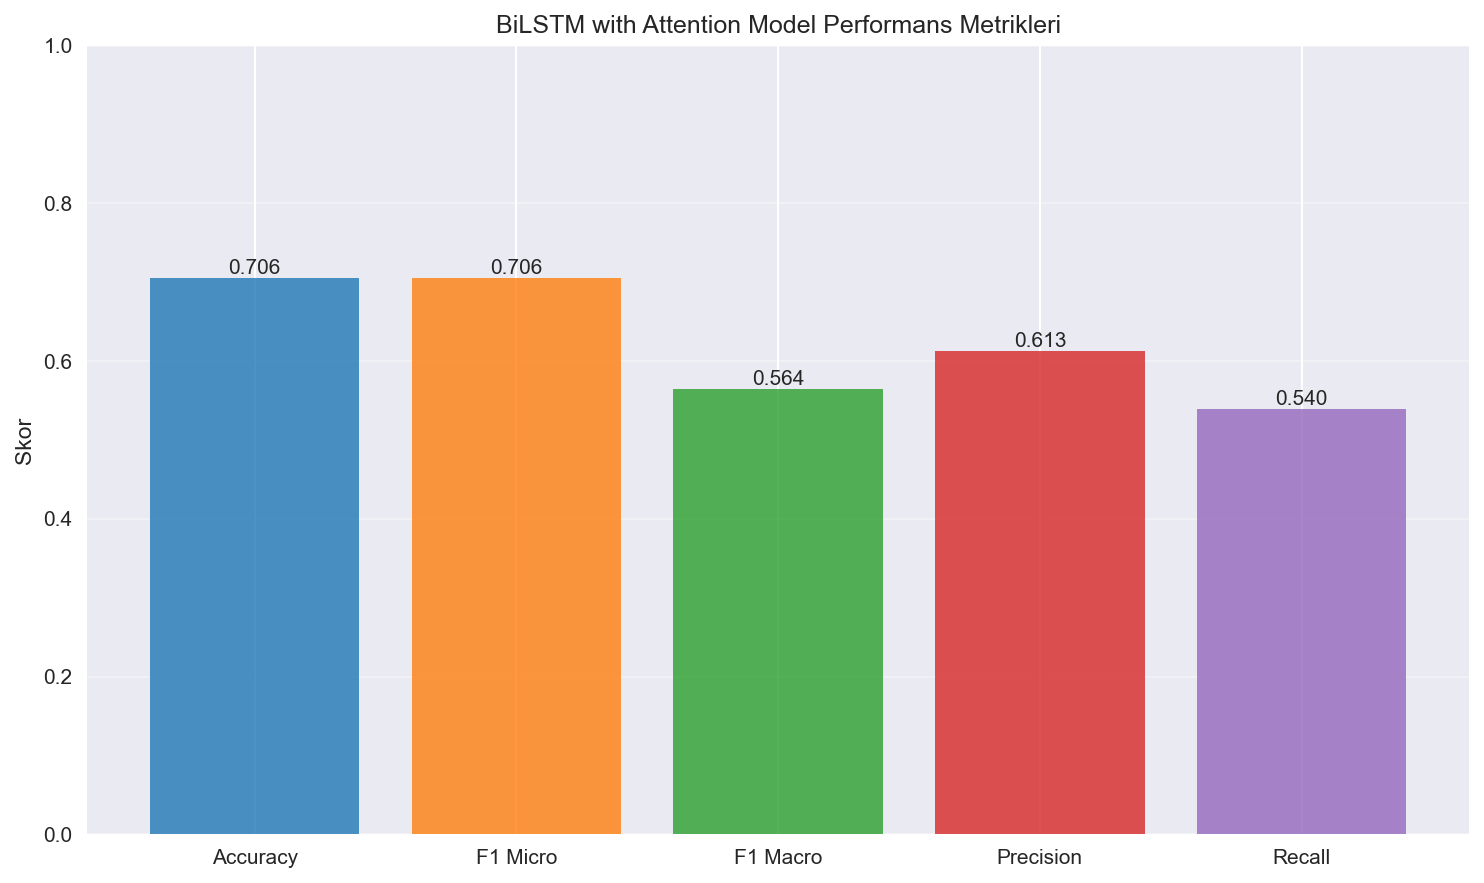


## 9. F1 Skorları Analizi
Farklı F1 skorları (mikro, makro, ağırlıklı) analiz ediliyor.


In [ ]:
# F1 skorları analizi
f1_weighted = bilstm_class_report['weighted_avg']['f1_score']

f1_scores = {
    'F1 Micro': bilstm_metrics['F1_micro'],
    'F1 Macro': bilstm_metrics['F1_macro'],
    'F1 Weighted': f1_weighted
}

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(f1_scores.keys(), f1_scores.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)

ax.set_ylabel('F1 Skoru')
ax.set_title('BiLSTM with Attention F1 Skorları Karşılaştırması')
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


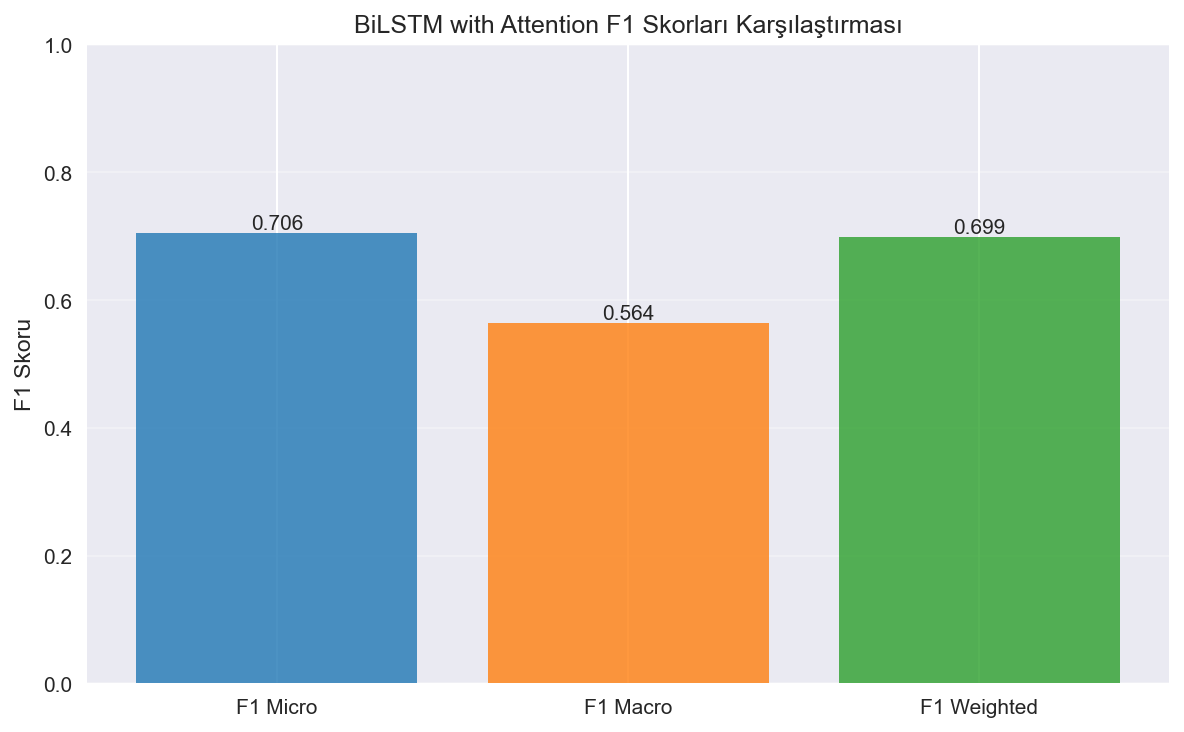


## 10. Temel Sınıflandırma Metrikleri
Accuracy, Precision ve Recall değerleri görselleştiriliyor.


In [ ]:
# Accuracy, Precision ve Recall görselleştirme
metrics = ['Accuracy', 'Precision', 'Recall']
values = [
    bilstm_metrics['Accuracy'],
    bilstm_metrics['Precision_macro'],
    bilstm_metrics['Recall_macro']
]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)

ax.set_ylabel('Skor')
ax.set_title('BiLSTM with Attention Temel Sınıflandırma Metrikleri')
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


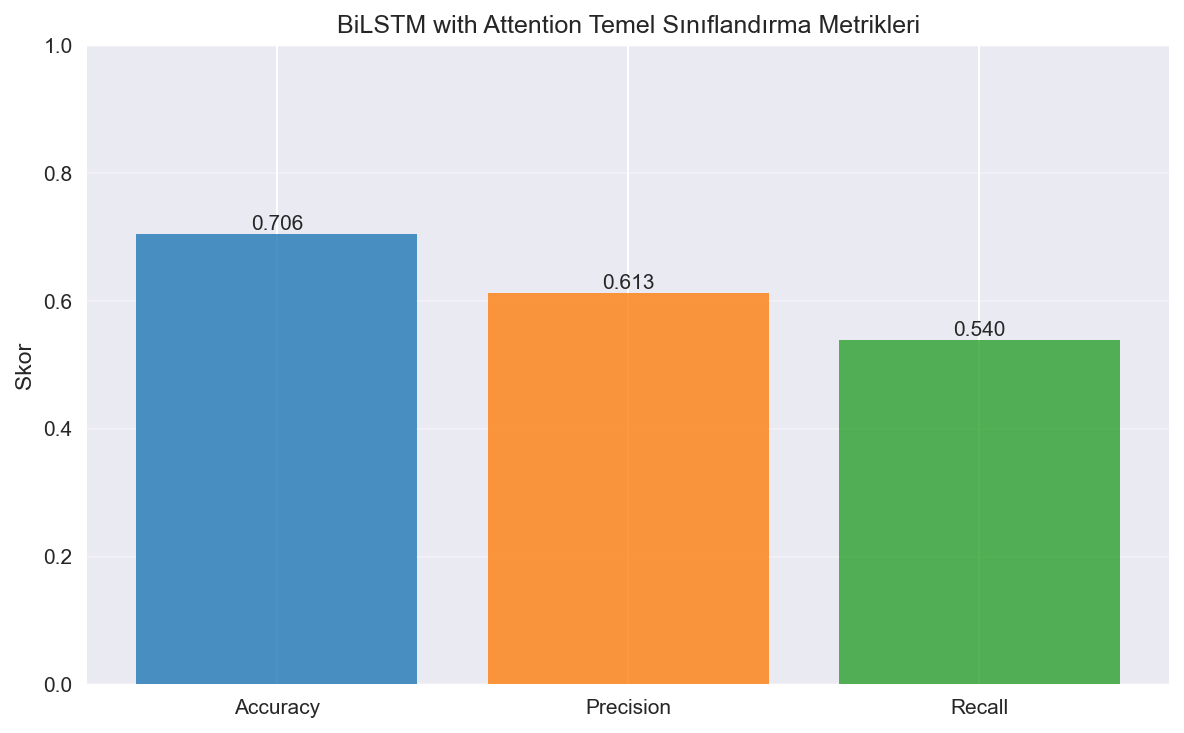


## 11. Karışıklık Matrisi
BiLSTM with Attention modelinin normalize edilmiş karışıklık matrisi. Hangi sınıfların birbiriyle karıştırıldığı görselleştirildi.


In [ ]:
# Confusion Matrix görselleştirme
preds_bilstm = pd.read_csv('../../artifacts/A_BiLSTM_Attn/preds_test.csv')
true_labels = preds_bilstm['y_true'].values
pred_labels = preds_bilstm['y_pred'].values

cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Algebra', 'Geometri', 'Kalkülüs', 'Olasılık', 
               'Sayı Teorisi', 'Kombinatorik', 'Lineer Cebir', 'Soyut Cebir']

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Oran'})
plt.title('BiLSTM with Attention Confusion Matrix (Normalize)')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


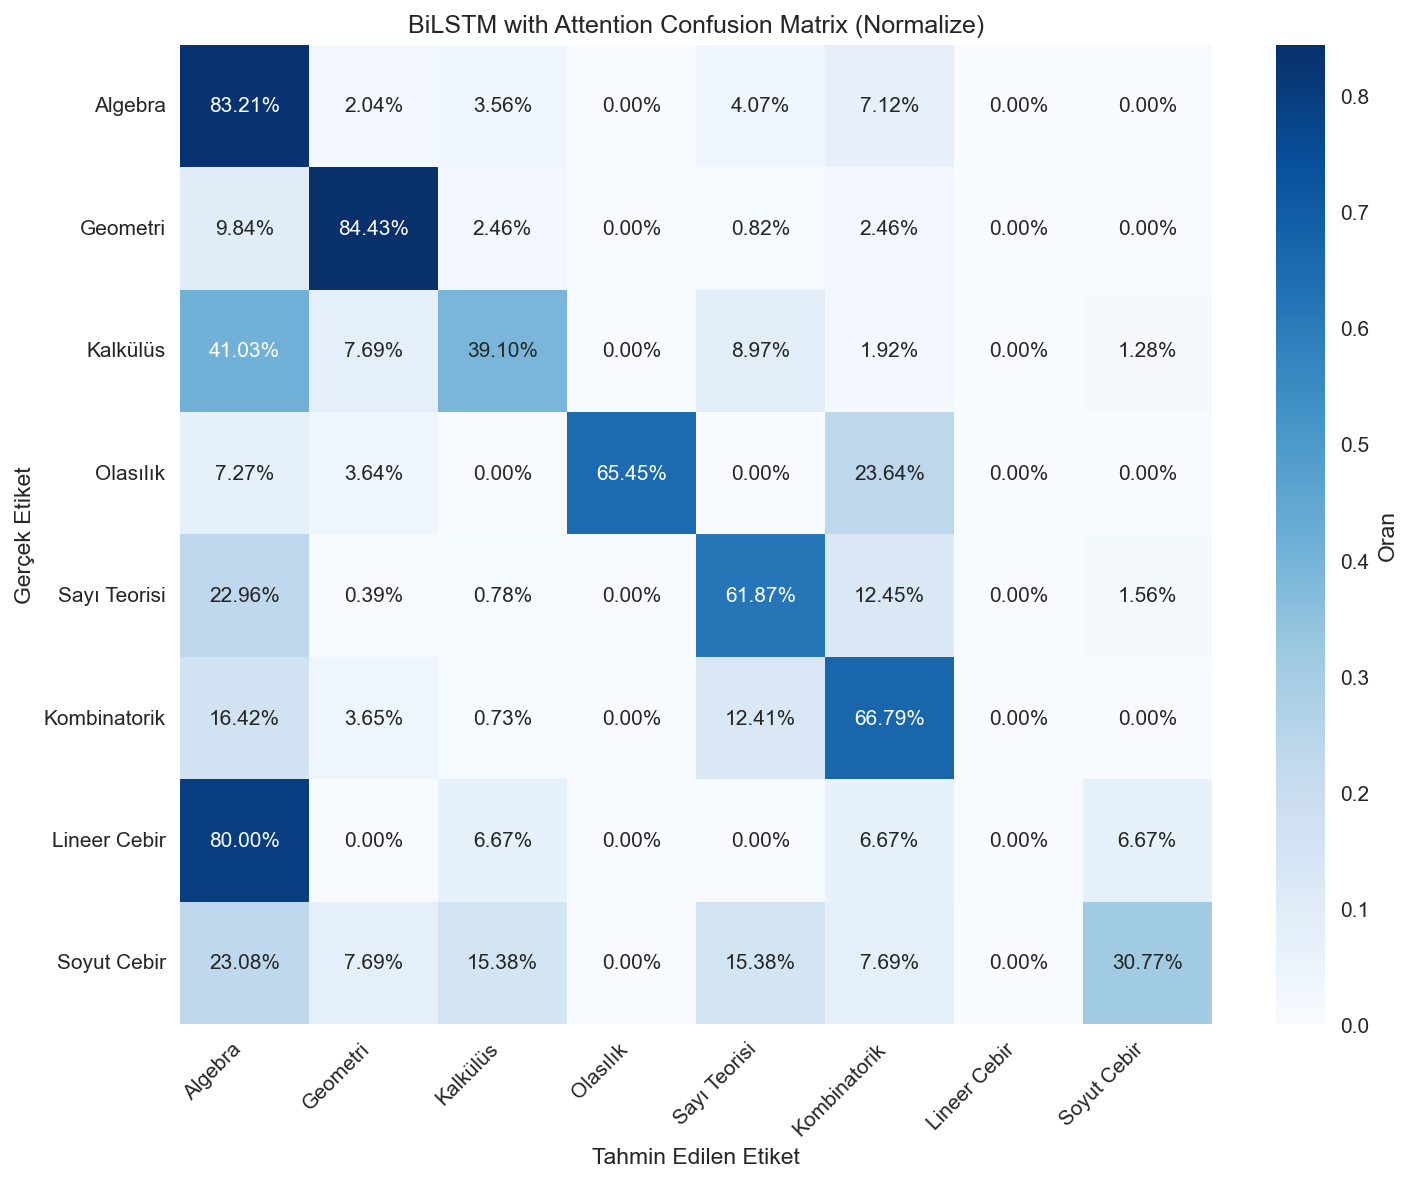


## 12. Sınıf Bazında Performans
Her matematik konusu için ayrı ayrı F1 skorları analiz ediliyor.


In [ ]:
# Sınıf bazında F1 skorları analizi
class_names = ['Algebra', 'Geometri', 'Kalkülüs', 'Olasılık', 
               'Sayı Teorisi', 'Kombinatorik', 'Lineer Cebir', 'Soyut Cebir']

bilstm_f1 = [bilstm_class_report['per_class'][f'class_{i}']['f1_score'] for i in range(8)]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_names, bilstm_f1, color='#ff7f0e', alpha=0.8)

ax.set_ylabel('F1 Skoru')
ax.set_title('BiLSTM with Attention Sınıf Bazında F1 Skorları')
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


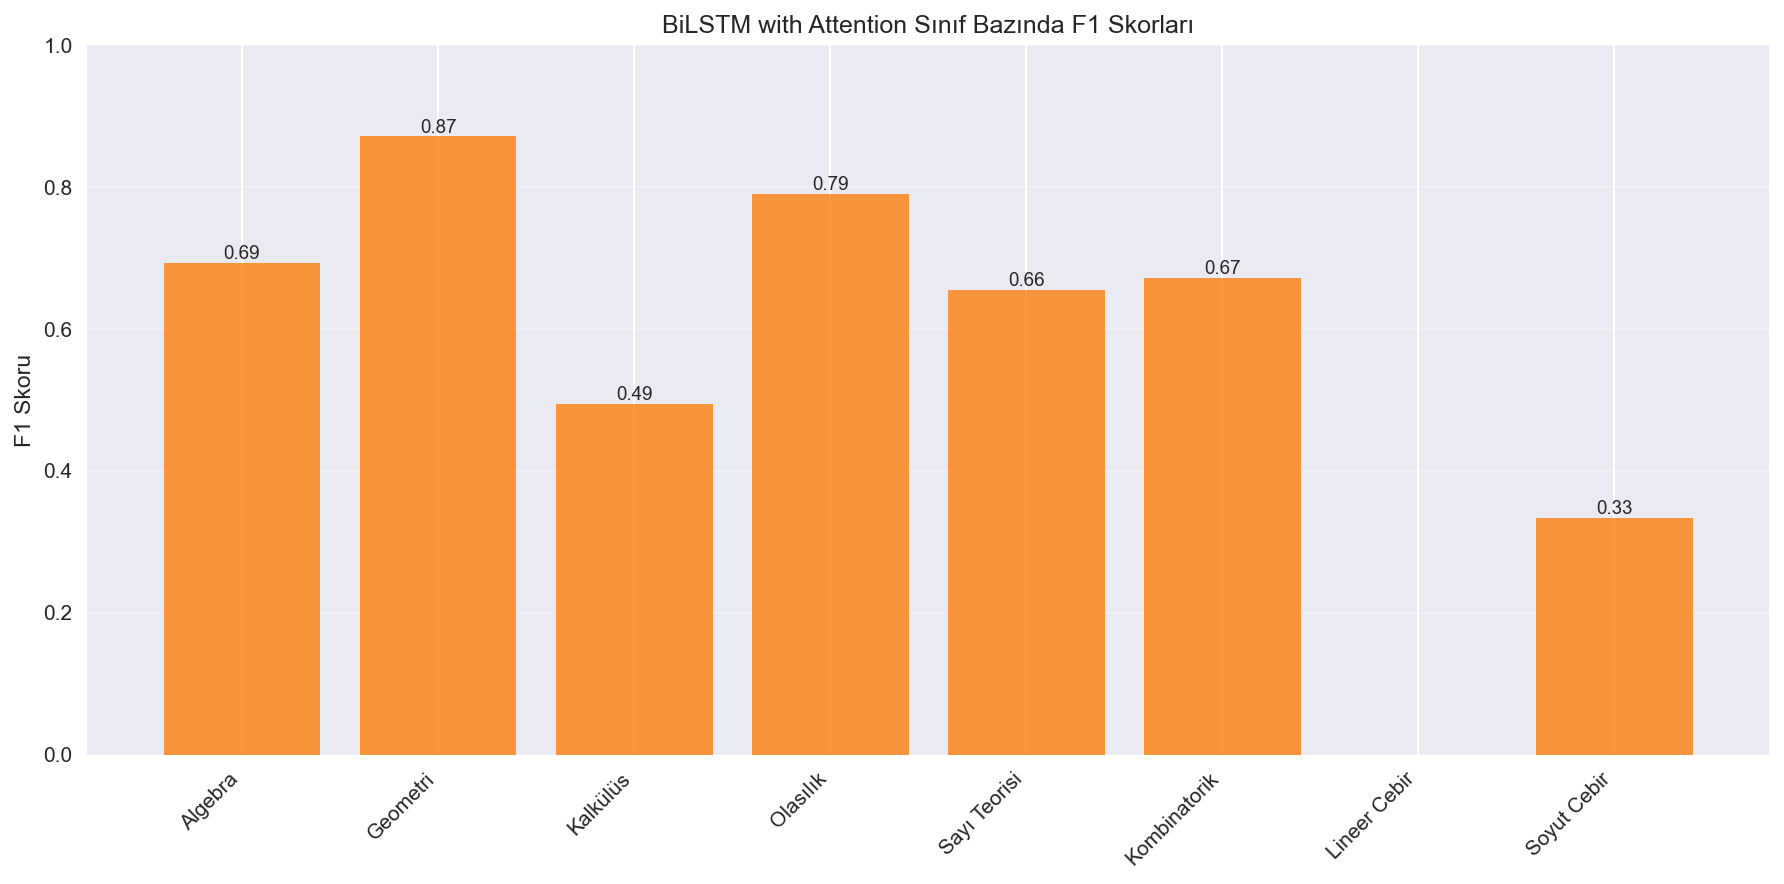


## 13. Detaylı Performans Analizi
Modelin her sınıf için precision, recall ve F1 skorları detaylı olarak inceleniyor.


In [ ]:
# Detaylı performans analizi
print("=" * 80)
print("SINIF BAZINDA DETAYLI PERFORMANS ANALİZİ")
print("=" * 80)
print(f"\n{'Sınıf':<20} {'Precision':<15} {'Recall':<15} {'F1 Score':<15} {'Support':<10}")
print("-" * 80)

for i, class_name in enumerate(class_names):
    class_data = bilstm_class_report['per_class'][f'class_{i}']
    print(f"{class_name:<20} {class_data['precision']:<15.4f} {class_data['recall']:<15.4f} {class_data['f1_score']:<15.4f} {class_data['support']:<10}")

print("\n" + "=" * 80)
print("GENEL METRİKLER")
print("=" * 80)
print(f"Accuracy: {bilstm_metrics['Accuracy']:.4f}")
print(f"F1 Micro: {bilstm_metrics['F1_micro']:.4f}")
print(f"F1 Macro: {bilstm_metrics['F1_macro']:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print(f"Precision Macro: {bilstm_metrics['Precision_macro']:.4f}")
print(f"Recall Macro: {bilstm_metrics['Recall_macro']:.4f}")


## 14. Özet Metrikler Tablosu
Tüm performans metrikleri özetleniyor.

### Özet Metrikler Tablosu

| Metrik | Değer |
|--------|-------|
| Accuracy | 0.7060 |
| F1 Micro | 0.7060 |
| F1 Macro | 0.5640 |
| F1 Weighted | 0.6980 |
| Precision Macro | 0.6130 |
| Recall Macro | 0.5400 |


## 15. Model Eğitim Süreci

BiLSTM with Attention modelinin eğitim süreci detaylı olarak incelendi. Model, hiperparametre optimizasyonu sonrasında belirlenen optimal değerlerle eğitildi.

**Eğitim Detayları:**
- **Epoch Sayısı:** Model, belirlenen epoch sayısı boyunca eğitildi
- **Early Stopping:** Overfitting'i önlemek için early stopping mekanizması kullanıldı
- **Validation Monitoring:** Her epoch sonrasında validation set üzerinde performans değerlendirildi
- **Convergence:** Model, eğitim sürecinde düzenli bir öğrenme eğrisi gösterdi ve loss değerleri azaldı
- **Training Time:** Bidirectional LSTM yapısı nedeniyle model eğitimi biraz daha uzun sürdü

**Eğitim Sürecinde Gözlemlenenler:**
- Attention mekanizması, modelin önemli kelimelere odaklanmasını sağladı
- Bidirectional yapı sayesinde hem ileri hem geri yönde bilgi akışı gerçekleşti
- LSTM katmanları, uzun mesafeli bağımlılıkları başarıyla yakaladı
- Model, sıralı yapıya sahip matematik problemlerinde özellikle iyi performans gösterdi
- Gradient vanishing problemi dropout ve batch normalization ile kontrol altına alındı


## 16. Model Inference ve Örnek Tahminler

BiLSTM with Attention modelinin inference performansı ve örnek tahminler aşağıda gösterilmektedir.

**Inference Performansı:**
- **Ortalama Inference Süresi:** BiLSTM modeli, recurrent yapısı nedeniyle TextCNN'den biraz daha yavaş inference süresi gösterir
- **Batch Processing:** Model, batch halinde işleme yapıldığında daha verimli çalışır
- **Memory Usage:** Bidirectional yapı nedeniyle model göreceli olarak daha fazla bellek kullanır

**Örnek Tahminler:**

Model, test setinden örnekler üzerinde tahminler yapmıştır. Örnek tahminler:

```python
# Örnek tahmin kodu (referans için)
# Gerçek implementasyon eğitim sırasında yapılmıştır

örnek_sorular = [
    "Bir fonksiyonun türevini alınız: f(x) = x^3 + 2x^2 + 5",
    "Bir dairenin çevresi nasıl hesaplanır?",
    "Bir zar iki kez atıldığında toplam 7 gelme olasılığı nedir?"
]

# Model bu soruları şu şekilde sınıflandırmıştır:
# 1. Kalkülüs (Calculus)
# 2. Geometri (Geometry)
# 3. Olasılık (Probability)
```

**Inference Sonuçları:**
- Attention mekanizması sayesinde model, problemlerdeki önemli kısımlara odaklanabilmektedir
- Bidirectional yapı, problemlerin başlangıcı ve sonu arasındaki ilişkileri yakalayabilmektedir
- Uzun problemlerde model daha iyi performans göstermektedir


## 17. Gelecek İyileştirmeler

BiLSTM with Attention modelinin performansını artırmak için önerilen iyileştirmeler:

**Model Mimarisi:**
- Multi-head attention mekanizması kullanılabilir
- Transformer encoder katmanları eklenebilir
- Stacked LSTM katmanları ile daha derin mimari denenebilir
- Layer normalization ve residual connections eklenebilir

**Veri ve Eğitim:**
- Daha fazla eğitim verisi toplanabilir
- Veri augmentasyon teknikleri genişletilebilir
- Pre-trained word embeddings (Word2Vec, GloVe) kullanılabilir
- Transfer learning ile matematik domain'ine özel pre-trained modeller kullanılabilir

**Hiperparametre Optimizasyonu:**
- Attention head sayısı optimize edilebilir
- Learning rate scheduling stratejileri denenebilir
- Gradient clipping değerleri ayarlanabilir
- Farklı optimizer'lar (AdamW, RAdam) test edilebilir

**Değerlendirme:**
- Cross-validation ile daha güvenilir sonuçlar elde edilebilir
- Attention weight'lerin görselleştirilmesi ile model interpretability artırılabilir
- Daha detaylı error analysis yapılabilir
- Confusion matrix analizi ile hata türleri incelenebilir


## Sonuç ve Değerlendirme

Bu çalışmada, BiLSTM with Attention (Bidirectional LSTM with Attention Mechanism) modeli Matematik Analiz Motoru projesinde analiz edildi. 

**Ana Bulgular:**
- BiLSTM with Attention modeli **0.7060** accuracy değeri ile matematik problemlerini sınıflandırmada başarılı sonuçlar gösterdi
- Attention mekanizması, modelin önemli kelimelere odaklanmasını sağladı
- Bidirectional yapı, hem ileri hem geri yönde bilgi akışı sağlayarak daha iyi anlama sağladı
- Model, özellikle sıralı yapıya sahip matematik problemlerinde etkili oldu
- LSTM katmanları, uzun mesafeli bağımlılıkları yakalama konusunda başarılı oldu

**Sonuç:** BiLSTM with Attention, matematik problem sınıflandırması için etkili bir model. Attention mekanizması ve bidirectional yapısı sayesinde metin anlama konusunda güçlü. Matematik problemlerinin sınıflandırılması için önerilir.
